## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


In [49]:
#tracked during:
df.timestamp.min(), df.timestamp.max()

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
users_converted = df.converted.sum()/df.converted.count()
users_converted

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
a = df.query('(landing_page == "new_page") & (group != "treatment")').timestamp.count()
b = df.query('(landing_page != "new_page") & (group == "treatment")').timestamp.count()
a+b

3893

In [7]:
x = df.query('(landing_page == "new_page") & (group != "treatment")')
y = df.query('(landing_page != "new_page") & (group == "treatment")')

f. Do any of the rows have missing values?

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [9]:
294478 - 3893

290585

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
df2 = df.drop(x.index)
df2 = df2.drop(y.index)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
df2.user_id.nunique()

290584

In [13]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
df2[df2.user_id.duplicated()]


,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [15]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
df2 = df2.drop([1899])
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
#probablity of converting
conversion_rate = df2.converted.sum()/df2.converted.count()
conversion_rate

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
df3 = df2.query('group == "control"')
conversion_control = df3.converted.sum()/df3.converted.count()
conversion_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
df4 = df2.query('group == "treatment"')
conversion_treatment = df4.converted.sum()/df4.converted.count()
conversion_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
new_landing = df2.query('landing_page == "new_page"').count()
p_new_landing = new_landing/df2.landing_page.count()

p_new_landing.landing_page

0.50006194422266881

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

> From the outputs above we can see the users were split in half and the same amount of users was testing the new page as the amount of people getting the old page, which should help us to get a non biased or further spoiled result.
>
> We can also see the total conversion rate (0.1196) is more or less the same as the conversion rate of those who were testing the old page (0.1204) and very similar to the new page testers (0.1188).
>
> At this point we can only observe a subtle difference, which doesn't seem to be very significant in real life and worth further resources.


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

H0: **$p_{new}$**  <=  **$p_{old}$**  
H1: **$p_{new}$**   >  **$p_{old}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [21]:
p_new = df2.query('landing_page =="new_page"').converted.mean()
p_new

0.11880806551510564

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [22]:
p_old = df2.query('landing_page =="old_page"').converted.mean()

p_mean = np.mean([p_new, p_old])

p_old, p_mean

(0.1203863045004612, 0.11959718500778342)

> Under the null, the following should apply:
> $p_{new_0} - p_{old_0}= 0$
>
> Therefore p_new, p_old should be both equal to p_mean (0.1196)

c. What is $n_{new}$?

In [23]:
n_new = df2.query('landing_page == "new_page"').count()
n_new[0]


145310

d. What is $n_{old}$?

In [24]:
n_old = df2.query('landing_page == "old_page"').count()
n_old[0]

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.choice([1, 0], size=n_new[0], p=[p_mean, (1-p_mean)])

new_page_converted.mean()

0.12049411602780263

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.choice([1, 0], size=n_old[0], p=[p_mean, (1-p_mean)])

old_page_converted.mean()

0.11914038300039924

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
new_page_converted.mean()-old_page_converted.mean()


0.0013537330274033949

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [28]:
p_diffs = []

for i in range(10000):
    new_page_converted = np.random.choice([1, 0], size=n_new[0], p=[p_mean, (1-p_mean)])
    old_page_converted = np.random.choice([1, 0], size=n_old[0], p=[p_mean, (1-p_mean)])
    p_diff = new_page_converted.mean()-old_page_converted.mean()
    p_diffs.append(p_diff)
    
p_diffs

[9.4185984810882251e-05,
 -0.00011228452835629343,
 -0.00058022228266460529,
 0.00097498631834599947,
 0.0013607990463962022,
 0.0027443726713519828,
 -0.0004700906915925257,
 -0.0027691654628154289,
 -0.0014336845571715773,
 0.0030468444429774949,
 -1.6170715352356591e-05,
 -0.0017502252680223346,
 0.00075490390562349408,
 3.8986317580466667e-05,
 0.00019041917384798879,
 -0.00020858593226950883,
 -0.00049762657376135888,
 0.00085830202522377275,
 -0.00068356924110780926,
 0.00049355945125933998,
 -0.0017022792106940465,
 0.00095438343616155441,
 0.0002456410109131224,
 0.0003970585188335235,
 -0.0023424147137850598,
 0.0003075843818467483,
 0.0014915676270907813,
 0.00037631238540924983,
 0.00056897999736799099,
 -0.00015344424768379272,
 0.00082379221414485837,
 -0.00018116772076193222,
 -0.0014818301430124803,
 0.0010990862317010741,
 0.00047965593310865529,
 0.0019253588145354272,
 0.00056228574944994225,
 -0.00015363695470879679,
 0.00076192217420303909,
 -0.0015578305155680289,


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

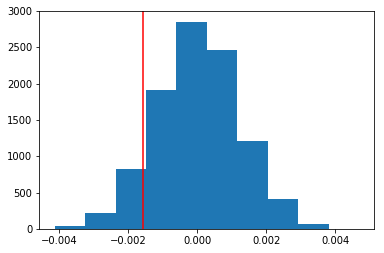

In [29]:
plt.hist(p_diffs)
plt.axvline(x=(p_new-p_old), color='r')
plt.show()

>Like expected, our histogram shows normal distribution. As per the test under the null hypotesis, the mean of this  distribution lays at 0.



j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
p_diff = p_new - p_old
p_diff

-0.0015782389853555567

In [31]:
greater_than_diff = [i for i in p_diffs if i > p_diff]
p_greater_than_diff = len(greater_than_diff)/len(p_diffs)
p_greater_than_diff

0.9032

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

>The probability for a conversion of a new page is lower than the total conversion rate and old page conversion rate.
>
> As per the hypothesis we would expect the proportion greater than our actual difference to be 0.5. But according to the outputs above, about 90% of the population in the simulated sample lies above the real difference. Therefore, we can conclude the new page really doesn't have better results than the existing one.
>
>The value we calculated in the part j is the observed difference of conversion rate between p_new and p_old. We reffer to this term as to the p-value.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

convert_old = len(df2[(df2['landing_page']=='old_page')&(df2['converted']==1)])
convert_new = len(df2[(df2['landing_page']=='new_page')&(df2['converted']==1)])

print("convert_old: ",convert_old, "\nn_old: ", n_old[0], "\nconvert_new: ", convert_new, "\nn_new: ", n_new[0])


convert_old:  17489 
n_old:  145274 
convert_new:  17264 
n_new:  145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [46]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old[0], n_new[0]], alternative='smaller')

z_score, p_value

(1.3109241984234394, 0.90505831275902449)

In [36]:
from scipy.stats import norm

 # Tells us how significant our z-score is
print(norm.cdf(z_score))

# Tells us what our critical value at 95% confidence is
print(norm.ppf(1-(0.05/2)))

0.905058312759
1.95996398454


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

Based on the z-score and our outputs above we can conclude, that the difference between simulated and real data differences is -1.31 standard deviations.
Using the one-tail test, our p-value calculated here is 0.9 which more or less corresponds to the p-value calculated above. 

Therefoere, we can confirm we dont have enough of evidence in order to reject the null hypothesis and agan, we fail to reject the null.



<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

> We can use logistic regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
df2['intercept'] = 1

In [38]:
df5 = pd.get_dummies(df2['landing_page'])
df5.head()

,new_page,old_page
0,0,1
1,0,1
2,1,0
3,1,0
4,0,1


In [39]:
df6 = pd.get_dummies(df2['group'])
df6.head()

,control,treatment
0,1,0
1,1,0
2,0,1
3,0,1
4,1,0


In [40]:
df_new = df2.join(df5, how = 'outer')
df_new = df_new.join(df6, how = 'outer')
df_new['ab_page'] = df_new['treatment']
df_new.head(1)

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,control,treatment,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,1,0,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [41]:
logit = sm.Logit(df_new['converted'], df_new[['ab_page', 'intercept']])

# Calculate results
result=logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [42]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 04 Jan 2019   Pseudo R-squ.:               8.077e-06
Time:                        12:26:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The result from the regression approach doesn't match our previous simulations. The reason why is this happening is that in our calculations above we used one-tail test and we were trying to prove whether or not the new page is better than the old page.

Using the regression approach gives us results considering the two-tail approach and is tyrng to reply to a question whether the conversion of one page is significantly different than the conversion of the other page.
H0 in this model would be that our 'ab_page' is totally insignificant when predicting the result. Again, we fail to reject H0.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> In my opinion we should only choose the variables in our model that might be very much correlated to the result. However, we should keep it simple and try not to add too many variables that may spoil the result. Too many variables might possibly cause multicollinearity and therefore wrong interpretation of results.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [50]:
df_countries = pd.read_csv('countries.csv')
df_countries.head(2)

,user_id,country
0,834778,UK
1,928468,US


In [51]:
df7 = pd.get_dummies(data=df_countries, columns=['country'])

In [52]:
df8 = df_new.merge(df7, on='user_id')
df8.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,control,treatment,ab_page,country_CA,country_UK,country_US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,1,0,0,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,1,0,0,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,1,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,1,1,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,1,0,0,0,0,1


In [53]:
logit_countries = sm.Logit(df8['converted'],df8[['intercept','country_UK', 'country_US']])

results = logit_countries.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [54]:
results.summary(0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      0   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 04 Jan 2019   Pseudo R-squ.:               1.521e-05
Time:                        13:09:24   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
country_UK     0.0507      0.028      1.786      0.074      -0.005       0.106
country_US     0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [55]:
logit_countries = sm.Logit(df8['converted'],df8[['intercept','country_UK', 'country_US', 'ab_page']])

results = logit_countries.fit()
results.summary(0)

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      0   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 04 Jan 2019   Pseudo R-squ.:               2.323e-05
Time:                        13:09:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
country_UK     0.0506      0.028      1.784      0.074      -0.005       0.106
country_US     0.0408      0.027      1.516      0.130      -0.012       0.093
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

>Even though the country seemed to have a little impact on the conversion rate, it is still not statistically significant.

To conclude the findings of this analysis, I would say even thought we expected the new page to conver better than the old one, we couldn't prove this alternative hypothesis based on our statistical tests performed above.

The difference in conversions of the new page vs the old page doesnt seem to be statistically significant as proven in the test. On the contrary, the performance showed in the histogram indicates the new page converts even slightly worse than the old one.

The countries where our customers were tracked didnt' seem to have much any significant influence on the results and the distribution of the new page vs the old was fair across the customers (50:50).

Therefore, we can conclude that based on the analysis above the new page tested here is not worth any more resources and the company in question could do better by implementing a different approach into their new landing page.

Other solution could be performing the time series analysis and tracking the conversion over time. Sometimes, giving the old customers more time to get used to the new landing page can help them to convert later. Our dataset only tracked about 3 weeks of usage.


<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  This is the final project in Term 1.  You should be very proud of all you have accomplished!


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [56]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0